# New Transformations in ServiceX

## Peter Onyisi, University of Texas at Austin

## What does ServiceX do?

   * Applies user-specified transformations to data from network-accessible sources
   * Provides client library to manage downloads of results or access via direct object store streaming

Documentation at [https://servicex-frontend.readthedocs.io/en/stable/](https://servicex-frontend.readthedocs.io/en/stable/)

What kinds of transformations are supported?

## Install ServiceX client

In [ ]:
! venv/bin/python3 -m pip install servicex

Some significant stability improvements have been made in the latest not-yet-released client library; to get this, use

In [ ]:
! venv/bin/python3 -m pip install git+https://github.com/ssl-hep/ServiceX_frontend.git@master

In [ ]:
# additional packages for this notebook
! venv/bin/python3 -m pip install uproot func_adl_servicex_xaodr22

In [1]:
from servicex import deliver, query, dataset

## Easier access to ServiceX for ATLAS users

ATLAS members now have instant access to the UChicago AF instance at [servicex.af.uchicago.edu](https://servicex.af.uchicago.edu/) using CERN SSO credentials.

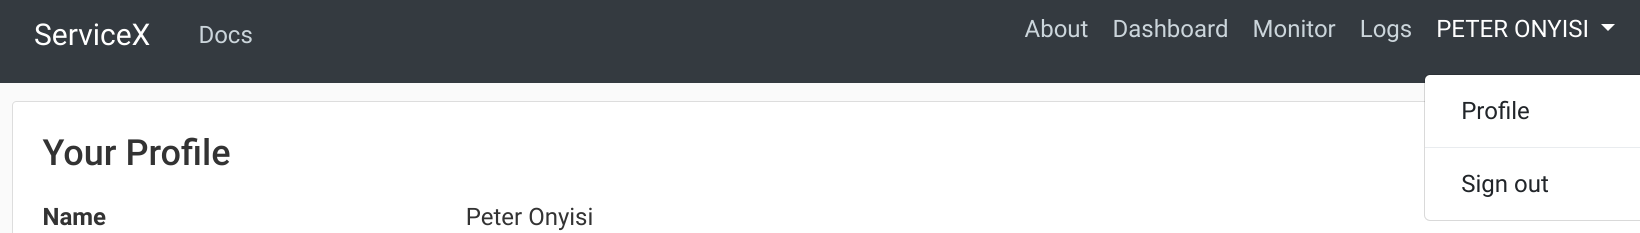

   * Once logged in, click on your name in the top right, choose "Profile", and click on the download button 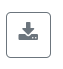
   * Copy the downloaded file to `servicex.yaml` in your working directory
   * The UChicago AF instance by default will be referred to as `servicex`
   * You can redirect the downloaded output by adding `cache_path: <outputdir>` to the `servicex.yaml` (default is `/tmp/servicex_$USER`)
   * Support channel: [ATLAS Talk category](https://atlas-talk.web.cern.ch/c/servicex/19)

## Where can we get the data from?

We support the current dataset specifications:
   * Rucio dataset (each ServiceX instance must be linked to a specific VO)
   * XRootD wildcard pattern (e.g., "all files in this EOS directory")
   * Explicit list of files (xrootd or http)
   * CERN OpenData portal dataset (needs update for new ATLAS catalog behavior)

## Transformation matrix
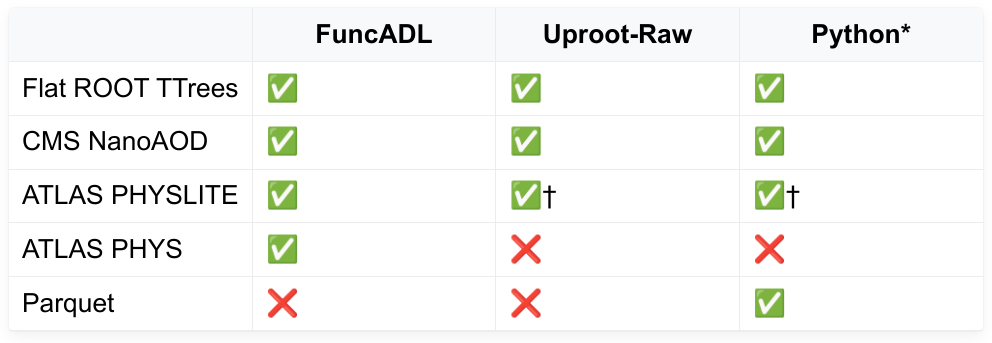
   * Not all transformations are supported on every input data type
   * The different transformers are associated with different query languages
   * The ATLAS PHYSLITE EDM is not _completely_ supported by `uproot`

## Uproot-raw
   * Effectively, queries are arguments to the `uproot` `iterate` function
   * Filtering of files that are readable by `uproot`
   * "Simple" expressions can be computed and used for cuts by specifying them in `awkward`-like syntax
   * Can run multiple expressions on multiple trees, also copy histograms from input to output files (useful for in-file metadata)
   * Output has `uproot` limitations if `TTree` output is used (e.g. no variable arrays of variable arrays)

## Uproot-raw Query

In [2]:
query_c_cut = query.UprootRaw(
        [
            {
                "treename": "reco",
                "filter_name": ['mu_phi', 'mu_eta', 'mu_charge', 'mu_e*', 'mu_pt*', 'mu_select*'],
                "cut": "any(log(jet_GN2v01_pc / ((jet_GN2v01_pb * 0.3) + (jet_GN2v01_pu * (1 - 0.3)))) > 0.828, axis=1)"

            }, 
            {
                'copy_histograms': ['CutBookkeeper*', 'cflow*', 'metadata', 'listOfSystematics']
            }
        ]
    )
spec = {
    'Sample': [
    {
        'Name': 'uprootrawquery',
        'Dataset': dataset.Rucio('user.mtost:user.mtost.all.Mar11'),
        'NFiles': 10,
        'Query': query_c_cut,
    },
    ],
}

print(f"Files: {deliver(spec, fail_if_incomplete=False)}")

Output()

Files: {'uprootrawquery': ['/tmp/servicex_ponyisi/a35ab42e-69d9-4769-b482-fe8864b08bdc/root___c027.af.uchicago.edu_1094__root___dcgftp.usatlas.bnl.gov_1094__pnfs_usatlas.bnl.gov_LOCALGROUPDISK_rucio_user_mtost_00_3a_user.mtost.43325015._000076.all_with_sys.root', '/tmp/servicex_ponyisi/a35ab42e-69d9-4769-b482-fe8864b08bdc/root___c028.af.uchicago.edu_1094__root___dcgftp.usatlas.bnl.gov_1094__pnfs_usatlas.bnl.gov_LOCALGROUPDISK_rucio_user_mtost_00_58_user.mtost.43325017._000513.all_with_sys.root', '/tmp/servicex_ponyisi/a35ab42e-69d9-4769-b482-fe8864b08bdc/root___c026.af.uchicago.edu_1094__root___dcgftp.usatlas.bnl.gov_1094__pnfs_usatlas.bnl.gov_LOCALGROUPDISK_rucio_user_mtost_00_0f_user.mtost.43325021._000288.all_with_sys.root', '/tmp/servicex_ponyisi/a35ab42e-69d9-4769-b482-fe8864b08bdc/root___c027.af.uchicago.edu_1094__root___dcgftp.usatlas.bnl.gov_1094__pnfs_usatlas.bnl.gov_LOCALGROUPDISK_rucio_user_mtost_00_34_user.mtost.43325183._000237.all_with_sys.root', '/tmp/servicex_ponyisi/a3

## Command line interface

The CLI is still being developed but provides a very convenient way of scripting ServiceX execution if you just want to run a query and download the output. The queries are specified in a YAML file (which can also be loaded in a notebook).

In [5]:
# %load example_request.yaml
Sample:
  - Name: Testing
    Dataset: !Rucio user.mtost:user.mtost.all.Mar11
    NFiles: 50
    Query: !UprootRaw |
      [{"treename": "reco",
        "cut": "any(log(jet_GN2v01_pc / ((jet_GN2v01_pb * 0.3) + (jet_GN2v01_pu * (1 - 0.3)))) > 0.828, axis=1)", 
        "filter_name": ["mu_phi", "mu_eta", "mu_charge", "mu_e*", "mu_pt*"]
        },
        {"copy_histograms": ["CutBookkeeper*", "cflow*", "metadata", "listOfSystematics"]}
        ]

In [ ]:
! venv/bin/servicex deliver example_request.yaml

## FuncADL
   * [FuncADL](https://iris-hep.org/projects/func-adl.html) is a domain-specific language for specifying queries on physics analysis data
   * Provides a way to access the (almost) full ATLAS PHYS/PHYSLITE EDM, in principle also run calibrations/systematic variations (updating for latest software releases)
   * For ATLAS EDM access, need to install appropriate accessory package, e.g. `func_adl_servicex_xaodr22`

## FuncADL Query

In [3]:
from func_adl_servicex_xaodr22 import FuncADLQueryPHYSLITE, cpp_float, cpp_vfloat
fadlquery = FuncADLQueryPHYSLITE()

fadlquery = fadlquery.Select(lambda e: { "evt": e.EventInfo("EventInfo"),
                                 "quads": e.Vertices("BPHY4Quads"),
                                 "muons": e.Muons("Muons"),
                                })
fadlquery = fadlquery.Select(lambda e: { "eventNumber": e.evt.eventNumber(),
                                "QUAD_mass": e.quads.Select(lambda q: q.auxdataConst[cpp_float]("QUAD_mass")),
                                "QUAD_RefTrackPx": e.quads.Select(lambda q: q.auxdataConst[cpp_vfloat]("RefTrackPx")),
                                "QUAD_RefTrackPy": e.quads.Select(lambda q: q.auxdataConst[cpp_vfloat]("RefTrackPy")),  
                                "QUAD_RefTrackPz": e.quads.Select(lambda q: q.auxdataConst[cpp_vfloat]("RefTrackPz")),                         
                                "QUAD_chi2": e.quads.Select(lambda q: q.chiSquared()),
                                "QUAD_dof": e.quads.Select(lambda q: q.numberDoF()),
                               }
                    )
request = { 'Sample': [ { 'Name': 'funcadlquery',
                         'Dataset': dataset.Rucio('user.ponyisi:user.ponyisi.mc23_13p6TeV.524546.MGPy8EG_23lo_S4b18p4NJ0_Upsi1S2mu_4mu_3pt2_v2.deriv.DAOD_BPHY4.e8548_a911_r14908_p5923'),
                         'Query': fadlquery,
                         'Codegen': 'atlasr22',
                        }
                      ]
          }
result = deliver(request)
import uproot
with uproot.open(result['funcadlquery'][0]) as f:
    f['atlas_xaod_tree'].arrays()[1].show()

Output()

{eventNumber: 730008,
 QUAD_mass: [2.4e+04],
 QUAD_RefTrackPx: [[-1.14e+04, -5.88e+03, -9.44e+03, 2.64e+03]],
 QUAD_RefTrackPy: [[1e+04, -1.99e+03, 8.16e+03, -467]],
 QUAD_RefTrackPz: [[6.26e+03, 6.31e+03, 5.84e+03, 3.21e+03]],
 QUAD_chi2: [1.08e+03],
 QUAD_dof: [5]}


## Python
   * Runs in an interpreter with `uproot` and `awkward` installed
   * User writes a function that provides `awkward` arrays to be serialized 

## Python Query

In [4]:
def run_query(input_filenames=None):
    import uproot
    with uproot.open({input_filenames: "CollectionTree"}) as o:
        br = o.arrays("AnalysisElectronsAuxDyn.pt")
    return br

request = { 'Sample': [ { 'Name': 'pythonquery',
                         'Dataset': dataset.Rucio('mc23_13p6TeV:mc23_13p6TeV.601189.PhPy8EG_AZNLO_Zee.deriv.DAOD_PHYSLITE.e8514_s4159_r15530_p6697'),
                         'Query': query.PythonFunction().with_uproot_function(run_query),
                         'NFiles': 100
                        }
                      ]
          }
result = deliver(request)
with uproot.open(result['pythonquery'][0]) as f:
    f['servicex'].arrays()[0].show()

Output()

{'nAnalysisElectronsAuxDyn.pt': 3,
 'AnalysisElectronsAuxDyn.pt': [6.05e+04, 3.57e+04, 5.12e+03]}


## Running from YAML

As mentioned earlier, the YAML file fed into the CLI can also be used directly in a notebook:

In [10]:
result = deliver('example_request.yaml')
with uproot.open(result['Testing'][0]) as f:
    f['reco'].arrays()[5].show()

Output()

{nmu_charge: 1,
 mu_charge: [-1],
 nmu_eta: 1,
 mu_eta: [-1.71],
 nmu_phi: 1,
 mu_phi: [-1.4],
 nmu_e_NOSYS: 1,
 mu_e_NOSYS: [8.2e+04],
 nmu_pt_NOSYS: 1,
 mu_pt_NOSYS: [2.87e+04]}


## What New Transformations Are Coming?

We have some new transformations planned for the very near future:
   * TopCPToolkit: run the ATLAS TopCPToolkit ntupler for PHYS/PHYSLITE &rarr; ntuple
   * RooDataFrame: run a `RooDataFrame` expression given in PyROOT

We also anticipate adding `RNtuple` support for output of the `uproot-raw` transformer when we upgrade to `uproot` 5.6.0 (see [this](https://github.com/scikit-hep/uproot5/pull/1395)).

Do you have a specific transformation workflow that you need? (Which is not terribly CPU-intensive?) Let us know!

## Thanks!